In [1]:
!pip install -q kaggle
!pip install torch
!pip install tqdm
!pip install transformers
!pip install livelossplot==0.5.4

     |████████████████████████████████| 2.8 MB 7.0 MB/s 
     |████████████████████████████████| 50 kB 8.3 MB/s 
     |████████████████████████████████| 895 kB 55.9 MB/s 
     |████████████████████████████████| 636 kB 63.8 MB/s 
     |████████████████████████████████| 3.3 MB 48.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [1]:
from google.colab import files
from abc import ABC, abstractmethod
from typing import List, Optional
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import seaborn as sns
from transformers import BertTokenizer, BertModel
from torch import nn, utils
from torch.utils.data import TensorDataset, RandomSampler, Dataset
import torch
from livelossplot import PlotLosses
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
#upload your kaggle.json file with permission to download jigsaw-toxic-comment-classification-challenge dataset
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"gabib3b","key":"817d7e169db4cbef867b22907320144c"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

mkdir: cannot create directory ‘/root/.kaggle’: File exists
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_labels.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
! ls  

'kaggle (1).json'   sample_submission.csv.zip   train.csv
 kaggle.json	    test.csv.zip	        train.csv.zip
 sample_data	    test_labels.csv.zip


In [5]:
!unzip train.csv.zip

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [6]:
!ls

'kaggle (1).json'   sample_submission.csv.zip   train.csv
 kaggle.json	    test.csv.zip	        train.csv.zip
 sample_data	    test_labels.csv.zip


In [3]:
SAMPLE_SIZE = 100000
BERT_MODEL_NAME = 'bert-base-uncased'

In [4]:
df = pd.read_csv("train.csv")[['id', 'comment_text', 'toxic']].sample(SAMPLE_SIZE)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 72901 to 39344
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            100000 non-null  object
 1   comment_text  100000 non-null  object
 2   toxic         100000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.1+ MB


In [6]:
df.sample(3)

,id,comment_text,toxic
48189,80cc97809eedd2fa,"""\n\n I Am Disappoint \n\nI got here by search...",0
66944,b310d02a1b3df7ae,Can non-admins not put a 3RR warning to Wiki u...,0
141803,f6a5c2df68706b5f,"January 2007 (UTC)\nG, I would be remiss visit...",0


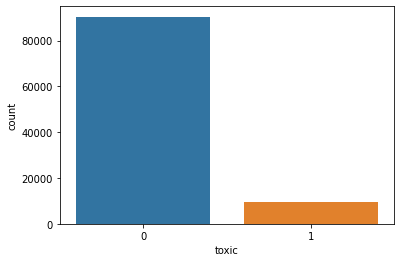

In [11]:
ax = sns.countplot(x="toxic", data=df)

In [7]:
df.rename(columns={'toxic': 'target'}, inplace = True)

train_df, validation_df = train_test_split(df, test_size = 0.2)
train_df.shape[0], validation_df.shape[0]

(80000, 20000)

In [8]:
class TextTokenizer:

  MAX_NUMBER_OF_WORDS_IN_SENTENSE = 512

  def __init__(self, bert_model_name):
    self._tokenizer = BertTokenizer.from_pretrained(bert_model_name)
    self._cls_token = "{} ".format(self._tokenizer.cls_token)
    self._sep_token = " {}".format(self._tokenizer.sep_token)
  
  def text_to_tokens_ids(self, text):

    marked_text = self._cls_token + text + self._sep_token
    tokenized_text = self._tokenizer.tokenize(marked_text)[0: TextTokenizer.MAX_NUMBER_OF_WORDS_IN_SENTENSE]
    indexed_tokens = self._tokenizer.convert_tokens_to_ids(tokenized_text)

    return indexed_tokens
  
  @property
  def pad_token_id(self):
    return self._tokenizer.pad_token_id

In [9]:
class BaseClassifier(ABC):

  @abstractmethod
  def fit(self, df: pd.DataFrame, validation_df: Optional[pd.DataFrame]):
    pass 

  @abstractmethod
  def predict(self, df: pd.DataFrame):
    pass 

  def evaluate(self, df: pd.DataFrame):
    predictions = self.predict(df)
    targets = df['target'].tolist()

    precision, recall, fscore, _ = precision_recall_fscore_support(targets, predictions, average='binary')

    return pd.DataFrame([(precision, recall, fscore)], columns = ['precision','recall', 'fscore'])


In [10]:
class NearestNeiborClassifier(BaseClassifier):

  def __init__(self, bert_model_name: str, hidden_layer: int, n_neighbors : int,
               device: torch.device):
    
    BaseClassifier.__init__(self)
    self._hidden_layer = hidden_layer
    self._n_neighbors = n_neighbors
    self._model = None
    self._device = device
    self._bert_model = BertModel.from_pretrained(bert_model_name, 
                                                  output_hidden_states = True).to(self._device)
    self._bert_model.eval()
    self._tokenizer = TextTokenizer(bert_model_name)

  def _text_to_sentense_embeddingds(self, text: str, hidden_layer: int):
    indexed_tokens = self._tokenizer.text_to_tokens_ids(text)
    tokens_tensor = torch.tensor([indexed_tokens]).to(self._device)
    segments_ids = [1] * len(indexed_tokens)
    segments_tensors = torch.tensor([segments_ids]).to(self._device)

    with torch.no_grad():
      outputs = self._bert_model(tokens_tensor, segments_tensors)
      hidden_states = outputs[2]
      
    return torch.mean(hidden_states[hidden_layer], dim=1).detach().cpu().numpy().flatten() if hidden_layer is not None else hidden_states
  
  def fit(self, df: pd.DataFrame, validation_df: Optional[pd.DataFrame]):
    
    X = df['comment_text'].progress_apply(lambda text: self._text_to_sentense_embeddingds(text, self._hidden_layer)).tolist()
    y = df['target'].tolist()

    self._model = KNeighborsClassifier(n_neighbors = self._n_neighbors)
    self._model.fit(X, y)

  def predict(self, df: pd.DataFrame):
    X = df['comment_text'].progress_apply(lambda text: self._text_to_sentense_embeddingds(text, self._hidden_layer)).tolist()
    
    return self._model.predict(X)

In [11]:
class DatasetLoader(Dataset):

    def __init__(self, df: pd.DataFrame):
        self._df = df

    def __len__(self):
        return len(self._df)

    def __getitem__(self, idx):
        row = self._df.iloc[idx]
        
        return row['id'], row['comment_text_tokens_ids'], row['target'] if 'target' in self._df.columns else -1

In [12]:
class RelevanceModel(nn.Module):

    def __init__(self, bert_model_name: str, hidden_layer: int, device: torch.device):

        super(RelevanceModel, self).__init__()

        self._hidden_layer= hidden_layer
        self._bert_model = BertModel.from_pretrained(bert_model_name, 
                                     output_hidden_states = True).to(device)

        self._bert_model.eval()

        for param in self._bert_model.parameters():
            param.requires_grad = False

        self.af1 = nn.LeakyReLU()
        self.fc1 = nn.Linear(768, 1)

    def forward(self, tokens, attention_mask):
        
        hidden_states = self._bert_model(tokens, attention_mask)[2]

        sentense_embeddingds = torch.mean(hidden_states[self._hidden_layer], dim=1)

        out = self.af1(sentense_embeddingds)

        out = self.fc1(out)

        return out

    def reset_parameters(self):
      
        initrange = 0.5
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        return self

In [15]:
class DenseLayerOnBertModel(BaseClassifier):

    def __init__(self, bert_model_name: str, hidden_layer: int, batch_size: int,
                 prediction_threshold: float, device, learnning_rate: float = 0.001,
                 number_of_epocs: int = 1000,
                 verbose_eval: bool = False):
        BaseClassifier.__init__(self)
        self._device = device
        self._model  = RelevanceModel(bert_model_name, hidden_layer, self._device).reset_parameters()
        self._model.to(self._device)
        
        self._batch_size = batch_size
        self._prediction_threshold = prediction_threshold
        self._learnning_rate = learnning_rate
        self._number_of_epocs = number_of_epocs
        self._tokenizer = TextTokenizer(bert_model_name)
        self._verbose_eval = verbose_eval
        

    def group_rows(self, rows):

      max_length = np.max([len(tokenes_ids) for _, tokenes_ids, _ in rows])

      ids = [id for id, _, _ in rows]

      tokenes_ids = torch.LongTensor([np.concatenate([tokenes_ids, np.repeat(self._tokenizer.pad_token_id, max_length - len(tokenes_ids))])
                    for id, tokenes_ids, target in rows])


      targets = [target for _, _, target in rows]

      masks = torch.LongTensor([np.concatenate([np.repeat(1, len(tokenes_ids)), np.repeat(0, max_length - len(tokenes_ids))])
            for _, tokenes_ids, _ in rows])
    
      return ids, tokenes_ids, masks, torch.FloatTensor(targets).reshape(-1, 1)

    def _calc_positive_weight(self, df: pd.DataFrame) -> float:
      weights = compute_class_weight('balanced', np.unique(train_df.target),  train_df.target)
      pos_weight = weights[1]/weights[0]

      return pos_weight   


    def _preprocessing(self, df: pd.DataFrame):
      df['comment_text_tokens_ids'] = df['comment_text'].progress_apply(lambda text: self._tokenizer.text_to_tokens_ids(text))

    def _run_batch(self, train_data_loader, loss_fn, optimizer):

      self._model.train()

      total_loss = 0.0

      for ids, tokends_ids, attention_mask, targets in train_data_loader:
                
        tokends_ids = tokends_ids.to(self._device)
        attention_mask = attention_mask.to(self._device)
        targets = targets.to(self._device)

        optimizer.zero_grad()

        output = self._model(tokends_ids, attention_mask)
        loss = loss_fn(output, targets)
    
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
      
      return total_loss/len(train_data_loader)

    def _evaluation_loss(self, data_loader, loss_fn):
      self._model.eval()

      total_loss = 0.0

      with torch.no_grad():
        for ids, tokends_ids, attention_mask, targets in data_loader:
          tokends_ids = tokends_ids.to(self._device)
          attention_mask = attention_mask.to(self._device)
          targets = targets.to(self._device)
          output = self._model(tokends_ids, attention_mask)
          loss = loss_fn(output, targets)

          total_loss += loss.item()

      return total_loss/len(data_loader)


    def fit(self, df: pd.DataFrame, valiodation_df: Optional[pd.DataFrame]):
        positive_weight = self._calc_positive_weight(df)
        pos_weights_tensor = torch.Tensor([positive_weight])
       
        self._preprocessing(df)
        train_dataset = DatasetLoader(df)
        sampler = RandomSampler(train_dataset)

        train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                        batch_size=self._batch_size,
                                                        shuffle=False,
                                                        num_workers=4,
                                                        drop_last=False,
                                                        sampler=sampler,
                                                        collate_fn= self.group_rows)


        validation_data_loader = None
        if self._verbose_eval and valiodation_df is not None:
          self._preprocessing(valiodation_df)
          validation_dataset = DatasetLoader(valiodation_df)

          validation_data_loader = torch.utils.data.DataLoader(validation_dataset,
                                                        batch_size=self._batch_size,
                                                        shuffle=False,
                                                        num_workers=4,
                                                        drop_last=False,
                                                        collate_fn= self.group_rows)
          

        optimizer = torch.optim.Adam(self._model.parameters(), lr=self._learnning_rate)
      
        loss_fn  = nn.BCEWithLogitsLoss(pos_weight = pos_weights_tensor).to(device)

        liveloss = PlotLosses() if self._verbose_eval else None
        for batch in range(self._number_of_epocs):
          train_batch = self._run_batch(train_data_loader, loss_fn, optimizer)

          validatiob_loss = None
          if validation_data_loader is not None:
            validatiob_loss = self._evaluation_loss(validation_data_loader, loss_fn)
          
          plot_update = {'train_loss': train_batch}

          if validatiob_loss is not None:
            plot_update['validation_loss'] = validatiob_loss

          if liveloss is not None:
            
            liveloss.update(plot_update)
            liveloss.draw()

    def predict(self, df: pd.DataFrame):

      self._preprocessing(df)
      
      self._model.eval()

      predict_dataset_loader = DatasetLoader(df)

      predict_data_loader = torch.utils.data.DataLoader(predict_dataset_loader,
                                                              batch_size=self._batch_size,
                                                              shuffle=False,
                                                              num_workers=4,
                                                              drop_last=False,
                                                              collate_fn=group_rows)
      with torch.no_grad():

        predictions = {}
        
        for ids, tokends_ids, attention_mask, _ in predict_data_loader:
          tokends_ids = tokends_ids.to(device)
          attention_mask = attention_mask.to(device)
          
          logit = self._model(tokends_ids, attention_mask)

          probs = torch.sigmoid(logit).detach().cpu().numpy().flatten()
          batch_predictions = probs > self._prediction_threshold

          for id, prediction in zip(ids, batch_predictions):
            predictions[id] = prediction 
          
      return df['id'].apply(lambda id: predictions[id]).tolist()
      

** NearestNeiborClassifier Example:**

In [16]:
test_nn_classifier = train_df.sample(1000)
nearest_neibor_classifier = NearestNeiborClassifier(bert_model_name = BERT_MODEL_NAME, 
                                                     hidden_layer = -1,
                                                     n_neighbors = 5,
                                                    device = device)

nearest_neibor_classifier.fit(test_nn_classifier, None)
nearest_neibor_classifier.evaluate(test_nn_classifier)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1000/1000 [00:11<00:00, 83.37it/s]


,precision,recall,fscore
0,0.906977,0.453488,0.604651


**DenseLayerOnBertModel Example:**

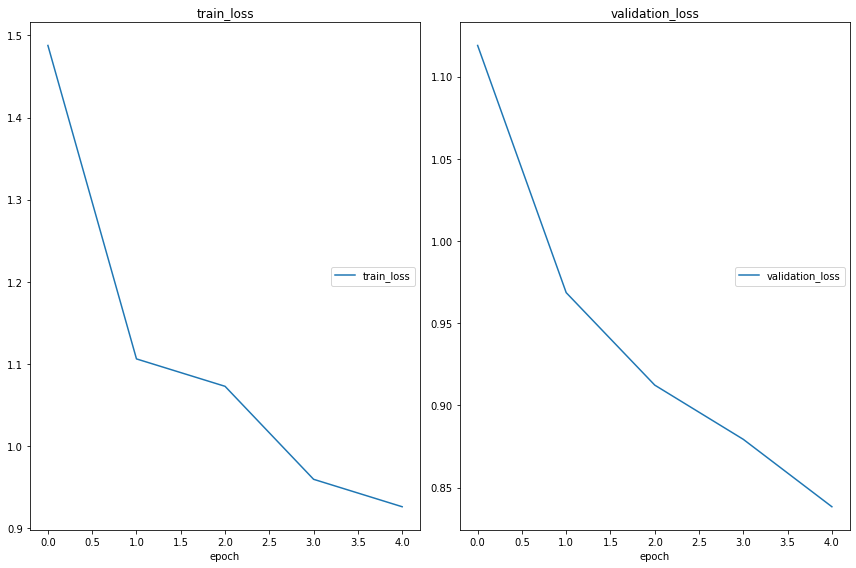

train_loss
	train_loss       	 (min:    0.926, max:    1.488, cur:    0.926)
validation_loss
	validation_loss  	 (min:    0.838, max:    1.119, cur:    0.838)


In [17]:
dense_model_classifier = DenseLayerOnBertModel(bert_model_name = BERT_MODEL_NAME, 
                                               hidden_layer = -1,
                                               batch_size = 32,
                                               prediction_threshold = 0.65,
                                               device = device, 
                                               learnning_rate= 0.001,
                                               number_of_epocs = 5,
                                               verbose_eval = True)



dense_model_classifier.fit(train_df.sample(1000), validation_df.sample(200))

In [18]:
BATCH_SIZE = 32
PREDICTION_THRESHOLD = 0.65 
N_NEIGHBORS = 3
NUMBER_OF_EPOCS = 8
EMBEDDING_LAYERS_TO_CHECK = range(0, 13) #[6, 7, 8, 9, 10 ,11 ,12]
scores_dfs = []

train_df = train_df.sample(2000)
validation_df = validation_df.sample(200)


for hidden_layer in EMBEDDING_LAYERS_TO_CHECK:

  print('running on hidden layer {}'.format(hidden_layer))

  dense_model_classifier = DenseLayerOnBertModel(bert_model_name = BERT_MODEL_NAME, 
                                               hidden_layer = hidden_layer,
                                               batch_size = BATCH_SIZE,
                                               prediction_threshold = PREDICTION_THRESHOLD,
                                               device = device, 
                                               learnning_rate= 0.001,
                                               number_of_epocs = NUMBER_OF_EPOCS,
                                               verbose_eval = False)


  dense_model_classifier.fit(train_df, None)
  scores_df = dense_model_classifier.evaluate(validation_df)
  scores_df['model'] = 'Deep'
  scores_df['hidden_layer'] = hidden_layer
  scores_dfs.append(scores_df)

  nearestNeiborClassifier = NearestNeiborClassifier(bert_model_name = BERT_MODEL_NAME, hidden_layer = 
                                                      hidden_layer, n_neighbors = N_NEIGHBORS,
                                                      device = device)


  nearestNeiborClassifier.fit(train_df, None)
  scores_df = nearestNeiborClassifier.evaluate(validation_df)

  scores_df['model'] = 'NearestNeighbor'
  scores_df['hidden_layer'] = hidden_layer
  scores_dfs.append(scores_df)


In [125]:
results_df = pd.concat(scores_dfs)

**Different Methods Results:**

In [126]:
results_df.sort_values(by=["model", 'hidden_layer'])

,precision,recall,fscore,model,hidden_layer
0,0.000000,0.000000,0.000000,Deep,0
0,0.500000,0.277778,0.357143,Deep,1
0,0.275862,0.444444,0.340426,Deep,2
0,0.321429,0.500000,0.391304,Deep,3
0,0.368421,0.388889,0.378378,Deep,4
0,0.636364,0.388889,0.482759,Deep,5
0,0.500000,0.444444,0.470588,Deep,6
0,0.428571,0.333333,0.375000,Deep,7
0,0.444444,0.444444,0.444444,Deep,8
0,0.615385,0.444444,0.516129,Deep,9


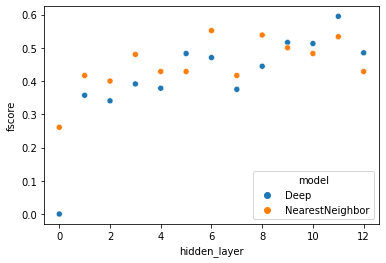

In [124]:
sns.scatterplot(data=results_df, x="hidden_layer", y="fscore", hue="model")


**Methods:**

I tried two methods, Nearest neighbor and Deep Neural network.

I both methods I used pretrained bert model, bert-base-uncased.

1. **Nearest neighbor classifier**:

   Input: Sentense embedding, mean on the words vectors from hidden layer..

   I didnt try to optimize the hyper paramaters like number of neighbors.


2. **Deep Neural network on top of Bert hidden layers**:
  
  I freezed bert weights, I selected one of its hidden layers and I calculated the mean of the words vectors (sentense embeddings). 

  I insered the sentense embeddings to fully connected layer that output logits 

  Optimizer: Adam with learnning rate 0.001

  Loss function: BCEWithLogitsLoss - with postive weights, since the dataset is imbalanced.

  I didnt try to optimize hyper paramaters, optimizers, loss function etc.


**Challnges:**

The dataset is highly imbalanced and I could try diffrent methods to deal with it. (like undersampling, oversampling)

The dataet is large and trainning on all of it in colab would take long time so 
I sampled smaller dataset and trained for short time (10 epocs).


**Conclussions:**
  
 I trained on small dataset and for low number of epocs so its difficult to jump intop conclusions but I will try.


I used the fscore to analyze the results.


In both model we can see clearly that the early layers (~0-5) give worse results than later layers (6-12).


In nearest neighbor it look like its the best to use some middle layer 6-8.


In the Deep model the last layers 8-12 are much better than earlier layers, and the best results is achived when using layer 11.








